## **Captcha Project using Clustering and Neural Networks**

In this project, we will only deal with simple text-based CAPTCHAs.  

The idea is to first split a CAPTCHA image into individual characters, and then use neural networks to recognise each character. Specifically, we will make use of K-means clustering to help us achieve this. For simplicity, throughout this assignment, we will assume that each CAPTCHA image only contains one row of characters.

## **Part 1** NumPy

The first exercise involves completing a function to generate a coordinate grid.

In [10]:
# Generate coordinates


import numpy as np

def generate_coordinates(height, width):
	"""
	Generates a coordinate grid.
	Args:
		height: the height of the grid
		width: the width of the grid
	Returns:
		A NumPy array of shape (height, width, 2), where grid[a, b] returns [a, b]
	"""
	# Your code goes here!
	x = np.arange(0, width).reshape(1, -1) # (1, width)
	y = np.arange(0, height).reshape(-1, 1) # (height, 1)

	x = np.broadcast_to(x, (height, width)) # (height, width)
	y = np.broadcast_to(y, (height, width)) # (height, width)

	return np.array([y, x]).transpose(1, 2, 0) # (yx, h, w) -> (h, w, yx)

The next part involves writing a function to initialize coordinates to be used as the centroids of the image.  Since each character in a CAPTCHA image uses approximately the same amount of space, a good estimate for initializing the centroids would be to take the middle of the y-axis and split the x-axis into equal parts.  For 5 characters, good initial centroids may look something as follows (the centroids are shown in red)

<center>

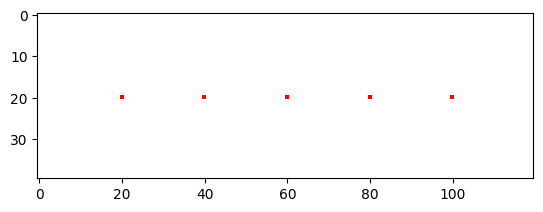

</center>

In [11]:
# Initialize centroids

def init_centroids(height, width, K):
	"""
	Initializes centroids.
	Args:
		height: the height of the image
		width: the width of the image
		K: the number of centroids to initialize
	Returns:
		A NumPy array of shape (K, 2) containing the coordinates of the centroids.  Each centroid is in [y, x] format.
	"""

	centroids = np.full((K, 2), fill_value=height / 2)
	centroids[:, 1] = np.arange(1, K+1) * (width / (K+1)) # (5, 2) meaning (5 centroids, xy)

	return centroids

## **Part 2** Text extraction

Now, it is time to separate a CAPTCHA image into background and text.  Since most CAPTCHA images contain mainly 2 colours, one for the text and one for the background, we will use 2 centroids to perform clustering on the RGB values of each pixel.  We first initialize 2 random RGB colours to be the centroids, then separate the text by finding which pixels are similar in colour to the 2 centroids.  In the end, one of the converged centroids should roughly represent the colour of the background, and the other the colour of the text.  

In [12]:
# Text extraction

def pixel_centroids_dist_1(img, centroid1, centroid2):
	"""
	Finds which pixels are closer in colour to each centroid.
	Does so by computing the SQUARED Euclidean distance between each pixel's RGB values and the RGB value of the two centroids.
	Args:
		img: a NumPy array image of shape (height, width, 3)
		centroid1: a NumPy array of shape (3,) containing the RGB values of the first centroid
		centroid2: a NumPy array of shape (3,) containing the RGB values of the second centroid
	Returns:
		a NumPy array of shape (2, height, width) containing the distances.
		Indexing the returned result by [0] should be the distance to centroid1, and indexing by [1] should be the distance to centroid2.
	"""

	dist1 = ((img - centroid1) ** 2).sum(axis=2) # (height, width)
	dist2 = ((img - centroid2) ** 2).sum(axis=2) # (height, width)

	return np.array([dist1, dist2]) # (2, height, width)

def assign_pixels_1(dist):
	"""
	For each pixel, assign it to the closest centroid.
	Args:
		dist: a NumPy array of shape (2, height, width) containing the distances to each centroid
	Returns:
		a NumPy array of shape (height, width) containing only 0s and 1s, where 0 indicates closer to centroid1, while 1 indicates closer to centroid2
	"""

	return dist.argmin(axis=0) # shape (height, width)

def recompute_centroids_1(img, cluster):
	"""
	Takes the mean RGB values to recompute the two centroids based on the current cluster membership.
	Args:
		img: a NumPy array image of shape (height, width, 3)
		cluster: a NumPy array of shape (height, width) containing only 0s and 1s, where 0 indicates closer to centroid1, while 1 indicates closer to centroid2
	Returns:
		A tuple containing the two centroids.  Each centroid is of shape (3,)
	"""

	layer1 = img[cluster == 0].mean(axis=0)
	layer2 = img[cluster == 1].mean(axis=0)

	return (layer1, layer2)

In [13]:
# Extracting text

RNJESUS_SEED = 122807528840384100672342137672332424407
rnjesus_generator = np.random.default_rng(seed=RNJESUS_SEED)

def extract_text(img, times=10):
	"""
	Uses clustering to find the text parts of a CAPTCHA image.  Assumes the image has only 2 main colours.
	Args:
		img: a NumPy array image of shape (height, width, 3)
		times: number of times to repeat steps 2 to 4 of the algorithm.  Don't change this!
	Returns:
		a boolean NumPy array of shape (height, width), where True indicates text, False indicates background
		Assumes text occurs less frequently than background
	"""
	# STEP 1 - initialise centroid (done for you)
	centroid1 = rnjesus_generator.integers(low=0, high=256, size=3) # [150, 172,  21]
	centroid2 = rnjesus_generator.integers(low=0, high=256, size=3) # [165, 183, 215]
	cluster = None

	for _ in range(times):


		dist = pixel_centroids_dist_1(img, centroid1, centroid2)

		cluster = assign_pixels_1(dist)

		centroid1, centroid2 = recompute_centroids_1(img, cluster)

	return cluster == 0 if (cluster == 0).sum() < (cluster == 1).sum() else cluster == 1

## **Part 3** Character separation

In [14]:
# Character separation

def pixel_centroids_dist_2(img, centroids):
	"""
	Finds the SQUARED Euclidean distance between each pixel and each centroid.
	Args:
		img: a NumPy array image of shape (height, width, 3)
		centroids: a NumPy array of shape (K, 2) containing the yx coordinates of each centroid.  K is the number of centroids.
	Returns:
		a NumPy array of shape (K, height, width) containing the distances.
		Indexing the returned result by [j] should be the distances from each pixel to centroid j
	"""

	height, width = img.shape[0], img.shape[1]
	K = centroids.shape[0]

	yx = centroids.reshape(K, 1, 1, 2) # (5 centroids, height, width, yx)
	coordinates = np.expand_dims(generate_coordinates(height, width), axis=0) # (1, height, width, 2)
	dist = (coordinates[:, :, :, 0] - yx[:, :, :, 0]) ** 2 + (coordinates[:, :, :, 1] - yx[:, :, :, 1]) ** 2 # (K, height, width)

	return dist

In [15]:
# Character separation

def assign_pixels_2(dist):
	"""
	For each pixel, assign it to the closest centroid
	Args:
		dist: a NumPy array of shape (K, height, width) containing the distances to each centroid
	Returns:
		a NumPy array of shape (height, width) containing only integers, where 0 indicates closest to centroid[0], 1 indicates closest to centroid[1], and so on.
	"""

	return dist.argmin(axis=0) # shape (height, width)

In [16]:

def recompute_centroids_2(img, text, cluster):
	"""
	Takes the mean location to recompute the centroids based on the current cluster membership.
	For each cluster, find all pixels corresponding to that cluster that are also text.
	Then, compute the mean x and y coordinates to determine the new centroid for that cluster.
	Args:
		img: a NumPy array image of shape (height, width, 3)
		text: a boolean NumPy array of shape (height, width), where True indicates text, and False indicates background
		cluster: a NumPy array of shape (height, width) containing only integers, where 0 indicates closest to centroid[0], 1 indicates closest to centroid[1], and so on.
	Returns:
		a NumPy array of shape (K, 2) containing the recomputed yx coordinates of each centroid.  K is the number of centroids.
	"""

	height, width = img.shape[0], img.shape[1]
	K = cluster.max() + 1

	coordinates = generate_coordinates(height, width).reshape(height, width, 1, 2) # (height, width, 1, 2) meaning (h, w, layers, yx)
	coordinates = np.broadcast_to(coordinates, (height, width, K, 2))

	cluster = cluster.reshape(height, width, 1) # (h, w, 1)
	cluster = (cluster == np.arange(0, K).reshape(1, 1, K)) # (h, w, K)
	text_reshaped = text.reshape(height, width, 1) # (h, w, 1)
	text_reshaped = np.broadcast_to(text_reshaped, (height, width, K)) # (h, w, K)

	idx = (text_reshaped & cluster).reshape(height, width, K, 1)
	idx = np.broadcast_to(idx, (height, width, K, 2))

	centroids = coordinates.mean(axis=(0, 1), where=idx)

	return centroids

In [17]:

def separate_characters(img, K, times=10):
	"""
	Uses clustering to separate the characters of the image.
	Args:
		img: a NumPy array image of shape (height, width, 3)
		K: the number of characters in the image
		times: number of times to repeat steps 2 to 4 of the algorithm.  Don't change this!
	Returns:
		a NumPy array of shape (height, width), where 0 indicates closest to centroid[0], 1 indicates closest to centroid[1], and so on.
		Background pixels are labelled -1.
	"""
	text = extract_text(img)
	cluster = None

	centroids = init_centroids(height=img.shape[0], width=img.shape[1], K=K) # (K, 2)

	for _ in range(times):


		dist = pixel_centroids_dist_2(img, centroids)

		cluster = assign_pixels_2(dist)

		centroids = recompute_centroids_2(img, text, cluster)

	cluster[~text] = -1

	return cluster

## ** Trying out the model **

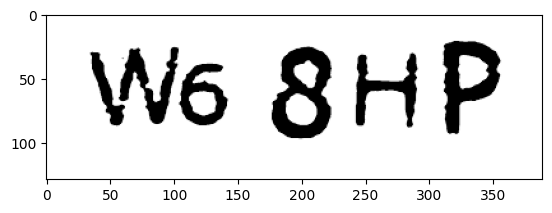

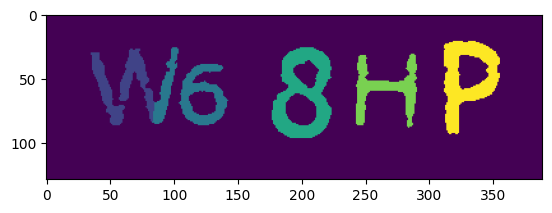

In [18]:
import cv2 as cv
import matplotlib.pyplot as plt


PATH = '/content/sample_data/cap2.png' # upload your image to the folder 'sample_data' using the small folder icon on the left.
K = 5

# # load the image
img = cv.imread(PATH)
img = cv.cvtColor(img, cv.COLOR_BGR2RGB) # By default, OpenCV loads as BGR format, so we need to convert it to RGB

# # show the original image
plt.imshow(img)
plt.show()

# # show the separated image
plt.imshow(separate_characters(img, K))
plt.show()

In [19]:
import zipfile
from google.colab import files

# Upload file
uploaded = files.upload()

# Extract the zip file
for filename in uploaded.keys():
    if filename.endswith('.zip'):
        with zipfile.ZipFile(filename, 'r') as zip_ref:
            zip_ref.extractall()
        print(f"Extracted {filename}")

Saving captcha.zip to captcha.zip
Extracted captcha.zip


In [20]:
import cv2
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import Model, layers, Sequential
import tensorflow.keras.layers as tfkl
from random import shuffle
%matplotlib inline
from matplotlib import pyplot as plt

PNG_FOLDER_NAME = '/content/samples/samples'
DEFAULT_CAPTCHA_LENGTH = 5

In [21]:
def delete_noisy_line(image:list):
    """ Some processes to delete line on the letters

    Args:
        image (list): input image that has been loaded recently

    Returns:
        image (list): converted image to approximately delete noisy line
    """
    image = cv2.blur(image, (3, 3))
    ret, image = cv2.threshold(image, 90, 255, cv2.THRESH_BINARY)

    image = cv2.dilate(image, np.ones((3, 1), np.uint8))
    image = cv2.erode(image, np.ones((2, 2), np.uint8))

    return image


def load_images_from_folder(folder:str, shuffled_files:list):
    """ This function load images from the determined folder

    Args:
        folder (str): the name of folder
        shuffled_files (list): list of files in determined folder those are shuffled

    Returns:
        images (list): the variable to save images
        splited_labels (list): return the characters of what images show
        unique_chars (dict): the unique characters that have been found in labels
    """
    images = []
    labels = []
    unique_chars = {}

    for filename in shuffled_files:
        img = cv2.imread(os.path.join(folder,filename), cv2.IMREAD_GRAYSCALE)
        img = delete_noisy_line(img)

        # Add image with its label to `images` and `labels`
        if img is not None:
            images.append(img)
            labels.append(filename.split('.')[0])

            # Find unique characters with their number
            for char in filename.split('.')[0]:
                if char in unique_chars:
                    unique_chars[char] += 1
                else:
                    unique_chars[char] = 1

    return images, labels, unique_chars



def preprocess_data(images:np.ndarray, labels:np.ndarray, unique_chars:dict, shuffled_files:list):
    """ This function apply preprocess images and labels to convert them to proper shape

    Args:
        images (np.ndarray): The images those are saved in the type of array
        labels (np.ndarray):  the labels in shape: (sample's count,)
        unique_chars (dict): unique chars that are found in captchas
        shuffled_files (list): list of files in determined folder those are shuffled

    Returns:
        X (np.ndarray): converted images in shape: (sample's count, height, width, 1)
        y (np.ndarray): converted labels in shape: (length of each example, sample's count, unique chars)
    """
    captcha_length = len(labels[0])
    unique_chars_count = len(unique_chars)

    X = np.zeros(images[...,  np.newaxis].shape)
    y = np.zeros((captcha_length, len(labels), unique_chars_count))

    for i, img in enumerate(shuffled_files):
        # Divide cells of images by 255 to learn more quickly in neural network
        captcha_img = images[i]
        captcha_img = captcha_img/255.0

        # Reshape `images`
        captcha_img = np.reshape(captcha_img, images[0, ...,  np.newaxis].shape)
        X[i] = captcha_img

        # Reshape `labels`
        curr_name = np.zeros((captcha_length, unique_chars_count))
        for j, char in enumerate(labels[i]):
            curr_name[j, list(unique_chars.keys()).index(char)] = 1
        y[:, i] = curr_name

    return X, y

In [22]:
# Shuffle folders' name to unorder the files
shuffled_files = os.listdir(PNG_FOLDER_NAME)
shuffle(shuffled_files)

images, labels, unique_chars = load_images_from_folder(PNG_FOLDER_NAME, shuffled_files)
images, labels = np.array(images), np.array(labels)
images, labels = preprocess_data(images, labels, unique_chars, shuffled_files)

unique_chars_count = len(unique_chars)

print(f"images' shape is {images.shape}")
print(f"labels' shape is {labels.shape}")
print(f"unique characters count equals: {unique_chars_count}")

images' shape is (1070, 50, 200, 1)
labels' shape is (5, 1070, 19)
unique characters count equals: 19


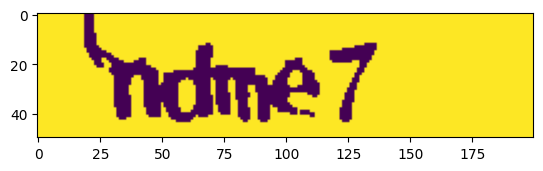

array of label number 32 equals:
 [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [23]:
index = 32
plt.imshow(images[index])
plt.show()
print(f"array of label number {index} equals:\n {labels[:, index]}")

In [24]:
class MyModel(Model):
    def __init__(self, num_classes):
        super(MyModel, self).__init__()

        self.layer1 = Sequential([
            tfkl.Conv2D(16, activation='relu', kernel_size=5, strides=1, padding="same"),
            tfkl.MaxPool2D(pool_size=(2, 2), padding='same'),
        ])
        self.layer2 = Sequential([
            tfkl.Conv2D(32, activation='relu', kernel_size=3, strides=1, padding="same"),
            tfkl.MaxPool2D(pool_size=(2, 2), padding='same'),
        ])
        self.layer3 = Sequential([
            tfkl.Conv2D(64, activation='relu', kernel_size=3, strides=1, padding="same"),
            tfkl.MaxPool2D(pool_size=(2, 2), padding='same'),
        ])
        self.layer4 = Sequential([
            tfkl.Conv2D(128, activation='relu', kernel_size=3, strides=1, padding="same"),
            tfkl.MaxPool2D(pool_size=(2, 2), padding='same'),
        ])
        self.layer5 = Sequential([
            tfkl.Conv2D(256, activation='relu', kernel_size=3, strides=1, padding="same"),
            tfkl.MaxPool2D(pool_size=(2, 2), padding='same'),
        ])
        self.layer6 = Sequential([
            tfkl.Flatten(),
            tfkl.Dropout(0.2),
            tfkl.BatchNormalization(),
        ])
        self.layer7_1 = Sequential([
            tfkl.Dense(64, activation='relu'),
            tfkl.Dropout(0.2),
            tfkl.BatchNormalization(),
            tfkl.Dense(num_classes , activation='softmax', name='char1'),
        ])
        self.layer7_2 = Sequential([
            tfkl.Dense(64, activation='relu'),
            tfkl.Dropout(0.2),
            tfkl.BatchNormalization(),
            tfkl.Dense(num_classes , activation='softmax', name='char2'),
        ])
        self.layer7_3 = Sequential([
            tfkl.Dense(64, activation='relu'),
            tfkl.Dropout(0.2),
            tfkl.BatchNormalization(),
            tfkl.Dense(num_classes , activation='softmax', name='char3'),
        ])
        self.layer7_4 = Sequential([
            tfkl.Dense(64, activation='relu'),
            tfkl.Dropout(0.2),
            tfkl.BatchNormalization(),
            tfkl.Dense(num_classes , activation='softmax', name='char4'),
        ])
        self.layer7_5 = Sequential([
            tfkl.Dense(64, activation='relu'),
            tfkl.Dropout(0.2),
            tfkl.BatchNormalization(),
            tfkl.Dense(num_classes , activation='softmax', name='char5'),
        ])

    def call(self, inputs):
        x = self.layer1(inputs)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        output1, output2, output3, output4, output5 = self.layer7_1(x), self.layer7_2(x), self.layer7_3(x), self.layer7_4(x), self.layer7_5(x)
        output = [output1, output2, output3, output4, output5]
        return output

In [25]:
input = tfkl.Input(images[0].shape)
output = MyModel(unique_chars_count)(input)

model = Model(inputs=input, outputs=output)

In [26]:
model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 50, 200, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ my_model (MyModel)              │ [(None, 19), (None,    │     1,561,567 │
│                                 │ 19), (None, 19),       │               │
│                                 │ (None, 19), (None,     │               │
│                                 │ 19)]                   │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,561,567 (5.96 MB)

 Trainable params: 1,553,759 (5.93 MB)

 Non-trainable params: 7,808 (30.50 KB)

In [27]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy', 'accuracy', 'accuracy', 'accuracy', 'accuracy'], optimizer='adam')

In [28]:
train_size = 0.8
numTrainingSamples = int(len(images) * train_size)
numTestingSamples = int(len(images) - numTrainingSamples)

X_train = images[:numTrainingSamples]
y_train = labels[:, :numTrainingSamples]
X_test = images[numTrainingSamples:]
y_test = labels[:, numTrainingSamples:]

In [29]:
history = model.fit(
    X_train,
    [y_train[0], y_train[1], y_train[2], y_train[3], y_train[4]],
    epochs=30,
    batch_size=32,
    validation_data=(
        X_test,
        [y_test[0], y_test[1], y_test[2], y_test[3], y_test[4]]
    )
    # Don't specify metrics - Keras will use defaults
)

Epoch 1/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 26s 596ms/step - loss: 17.9898 - my_model_accuracy: 0.0624 - my_model_accuracy_1: 0.0598 - my_model_accuracy_2: 0.0575 - my_model_accuracy_3: 0.0485 - my_model_accuracy_4: 0.0682 - my_model_loss: 3.5964 - val_loss: 14.9041 - val_my_model_accuracy: 0.0935 - val_my_model_accuracy_1: 0.0514 - val_my_model_accuracy_2: 0.0561 - val_my_model_accuracy_3: 0.0841 - val_my_model_accuracy_4: 0.0467 - val_my_model_loss: 2.9763
Epoch 2/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 19s 533ms/step - loss: 16.8561 - my_model_accuracy: 0.0760 - my_model_accuracy_1: 0.0834 - my_model_accuracy_2: 0.0718 - my_model_accuracy_3: 0.0714 - my_model_accuracy_4: 0.0751 - my_model_loss: 3.3553 - val_loss: 14.5380 - val_my_model_accuracy: 0.1168 - val_my_model_accuracy_1: 0.0607 - val_my_model_accuracy_2: 0.0654 - val_my_model_accuracy_3: 0.0654 - val_my_model_accuracy_4: 0.0467 - val_my_model_loss: 2.9068
Epoch 3/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 15s 549ms/step - loss: 14.1983 - my_model_accura

In [30]:
modelEvaluation = model.evaluate(X_test, [y_test[0], y_test[1], y_test[2], y_test[3], y_test[4]])

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - loss: 1.0117 - my_model_accuracy: 0.9913 - my_model_accuracy_1: 0.9675 - my_model_accuracy_2: 0.9309 - my_model_accuracy_3: 0.8517 - my_model_accuracy_4: 0.9733 - my_model_loss: 0.1534


In [31]:
print(f'Character1 Prediction Accuracy : {modelEvaluation[6]*100} %')
print(f'Character2 Prediction Accuracy : {modelEvaluation[7]*100} %')
print(f'Character3 Prediction Accuracy : {modelEvaluation[8]*100} %')
print(f'Character4 Prediction Accuracy : {modelEvaluation[9]*100} %')
print(f'Character5 Prediction Accuracy : {modelEvaluation[10]*100} %')

Character1 Prediction Accuracy : 99.06542301177979 %
Character2 Prediction Accuracy : 95.32710313796997 %
Character3 Prediction Accuracy : 92.52336621284485 %
Character4 Prediction Accuracy : 86.44859790802002 %
Character5 Prediction Accuracy : 98.13084006309509 %


In [32]:
def draw_loss_diagram_of_history(curr_history):
    plt.plot(curr_history.history['loss'])
    plt.plot(curr_history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

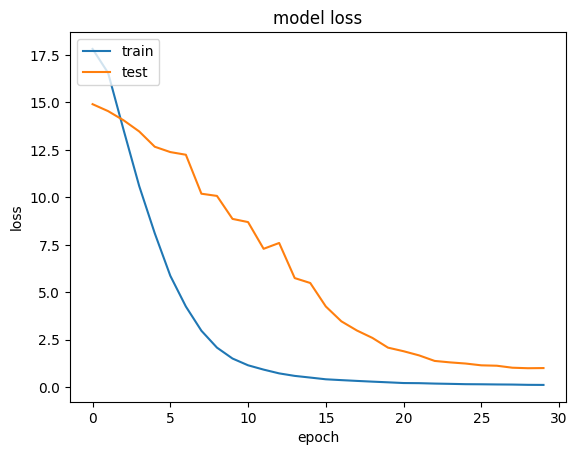

In [33]:
draw_loss_diagram_of_history(history)

In [34]:
characters = list(unique_chars.keys())
predicted_word = []
true_word = []

for i, sample in enumerate(X_test):
    sample = np.reshape(X_test[i] , images[0][np.newaxis, :].shape)
    sample = model.predict(sample)
    sample = np.reshape(sample ,(DEFAULT_CAPTCHA_LENGTH, unique_chars_count))
    predicted = ''.join([characters[np.argmax(i)] for i in sample])
    predicted_word.append(predicted)

for i in range(0, numTestingSamples):
    temp = ''.join([characters[i] for i in (np.argmax(y_test[:, i],axis=1))])
    true_word.append(temp)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━

In [35]:
predicted_word = np.array(predicted_word)
true_word = np.array(true_word)
df = pd.DataFrame({'Predicted_value': predicted_word, 'True_value': list(true_word)}, columns=['Predicted_value', 'True_value'])
print(df)

    Predicted_value True_value
0             6cwxe      6cwxe
1             m5ym2      m5ym2
2             ef4nn      ef4mn
3             y4g3b      y4g3b
4             mxycw      mxyxw
..              ...        ...
209           573bn      573bn
210           28x47      28x47
211           f2bge      f2fge
212           d666m      d666m
213           72m6f      72m6f

[214 rows x 2 columns]


In [36]:
df.to_csv('result.csv', index=False)